# PySP开发测试区

## 0. 测试准备

### 0.1 测试环境导入

In [12]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### 0.2 测试数据生成

> 测试数据1: 仿真AM-FM信号

In [13]:
import numpy as np

fs=2000
t= np.arange(0,1,1/fs)
A = (1+0.3*np.cos(2*np.pi*50*t))
IF= 100*(1+0.2*np.cos(2*np.pi*5*t))
Phase= np.cumsum(2*np.pi*IF)*(1/fs)+ np.pi/3
Data = A*np.cos(Phase)
del t, A, IF, Phase

## 1. Signal模块测试

### 1.1 Signal.Signal()

Signal(data=[ 0.18990794 -0.29600293 -0.73350692 ...  1.21319868  1.0072883
  0.64815325], fs=2000, label=测试信号)


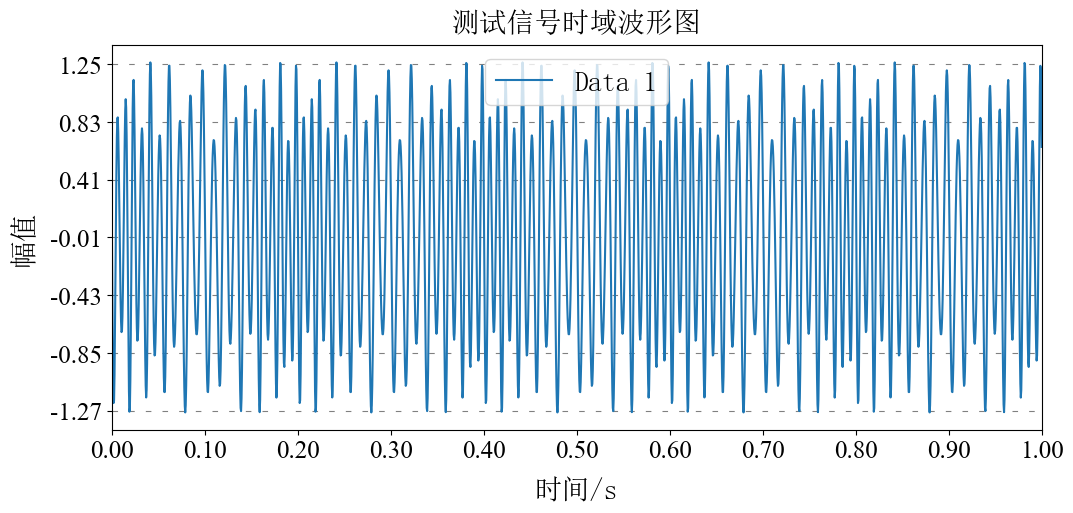

In [14]:
from PySP.Signal import Signal


res = Signal(data=Data, fs=fs, label="测试信号")
print(repr(res))
res.plot()

### 1.2 Signal.Resample()

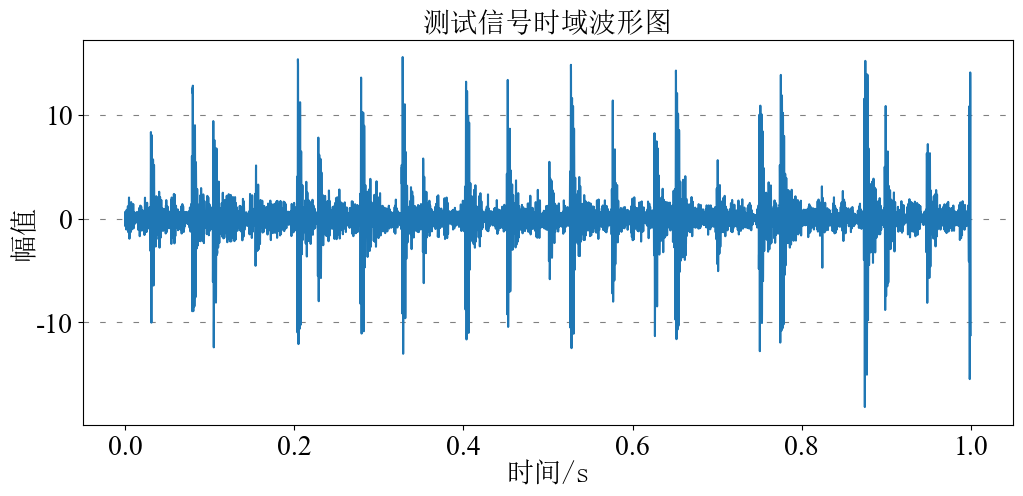

Signal(data=[-5.16416045  1.52336715 -0.14170794 ... -4.61200431  1.214855
  5.09735676], fs=2000, label=重采样测试信号)


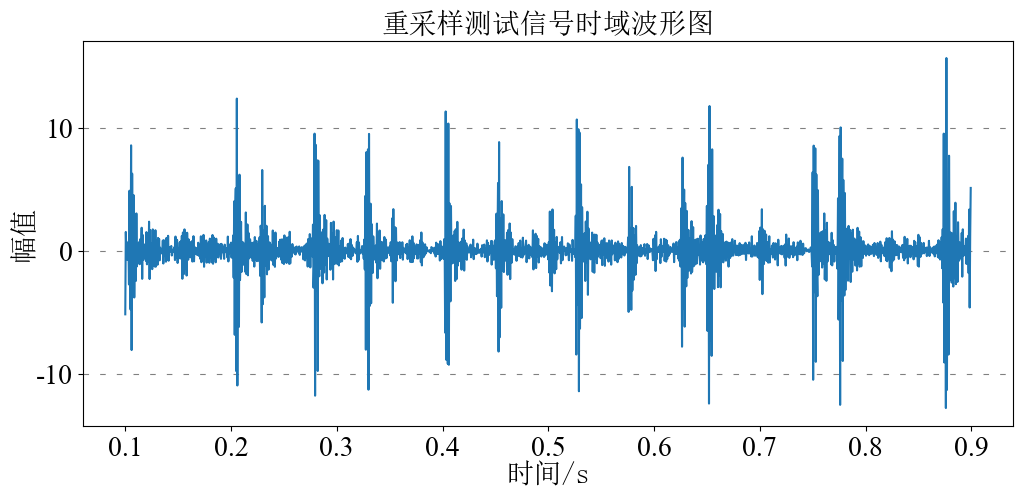

In [ ]:
from PySP.Signal import Signal,Resample

res = Signal(data=Data,fs=12000,label='测试信号')
res.plot()
res=Resample(Sig=res,fs_resampled=2000,t0=0.1,T=0.8)
print(repr(res))
res.plot()

### 1.3 Signal.Periodic()

Signal(data=[ 3.10108278 -0.19146163  0.83404454 ...  1.24776264  2.83351624
  0.92561786], fs=1000, label=仿真含噪准周期信号)


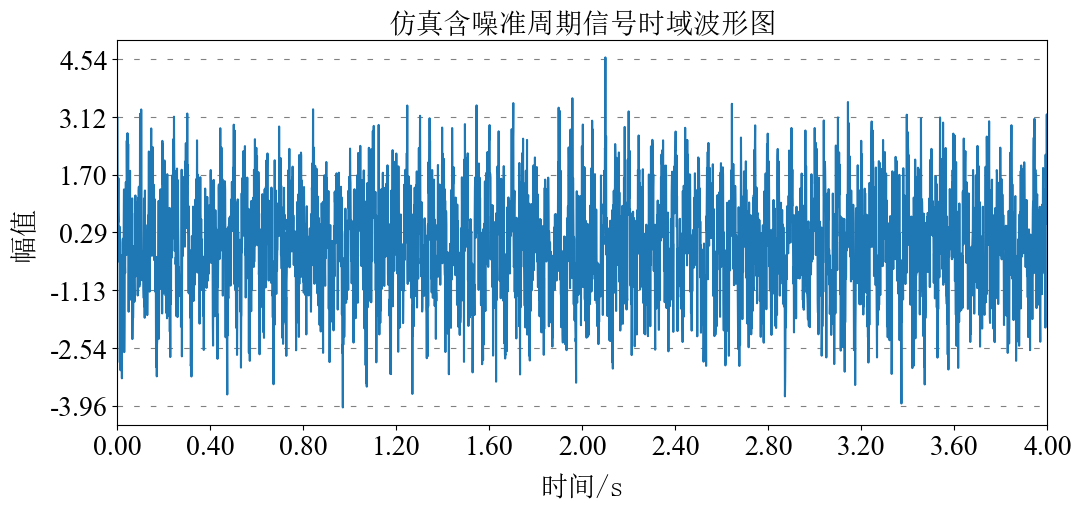

In [26]:
from PySP.Signal import Periodic

try:
    res = Periodic(fs=1000,T=4,CosParams=((20,1,32),(50,0.5,0)),noise=1)
    print(repr(res))
    res.plot()
except Exception as e:
    print(e)

## 2. Analysis模块测试

### 2.1 Analysis.Analysis()

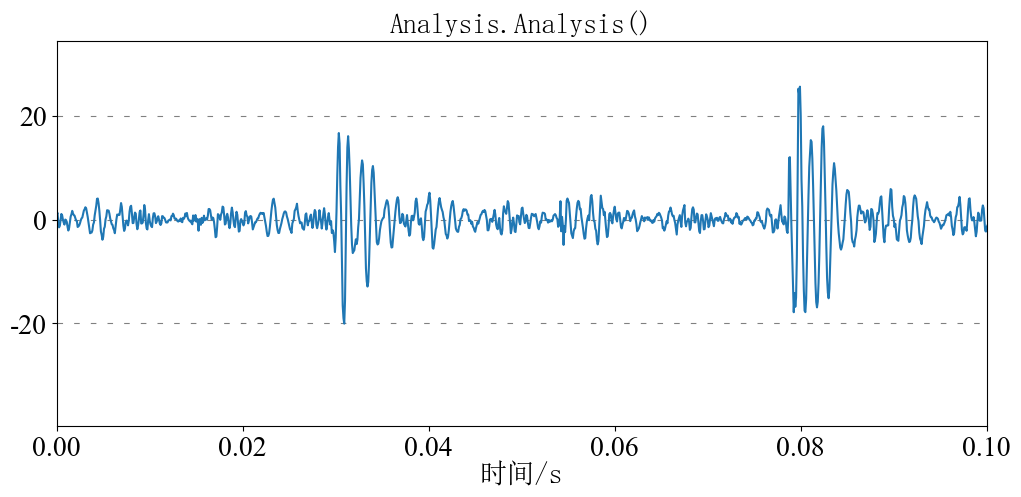

In [13]:
from PySP.Analysis import Analysis
from PySP.Signal import Signal
from PySP.Plot import LinePlotFunc
from PySP.decorators import InputCheck

try:

    class TestAnalysis(Analysis):

        @Analysis.Plot(LinePlotFunc)
        @InputCheck({"x": {"OpenLow": 0}})
        def run(self, x: float):
            t_Axis = self.Sig.t_Axis
            data = self.Sig.data * x
            return t_Axis, data

    Sig = Signal(data=Data, fs=fs)
    test = TestAnalysis(
        Sig,
        isPlot=True,
        xlabel="时间/s",
        xlim=(0, 0.1),
        title="Analysis.Analysis()",
        height=2,
    )
    test.run(2.0)

except Exception as e:
    print(e)

## 2. Plot模块测试

### 2.1 Plot.Plot()

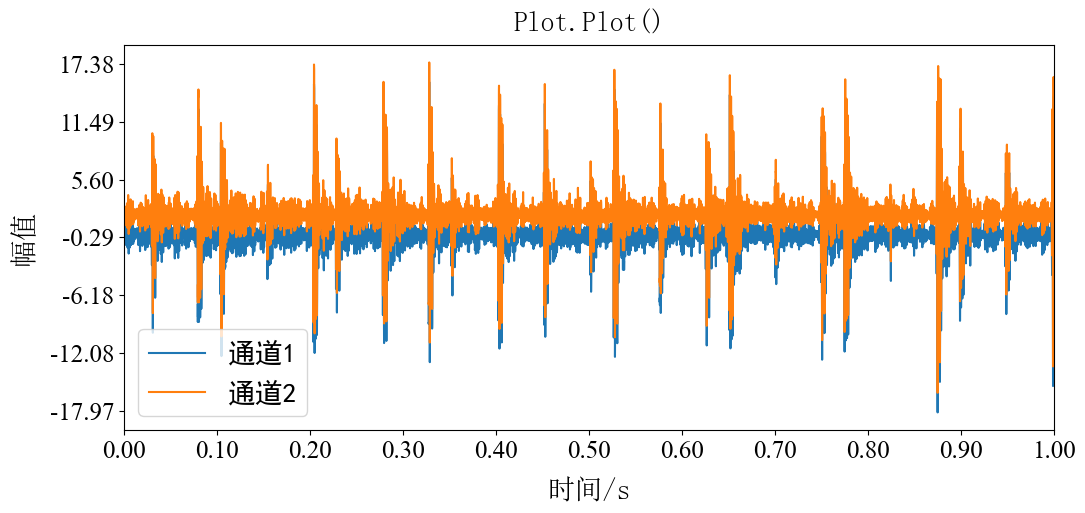

In [58]:
from PySP.Plot import Plot
from PySP.Signal import Signal

try:
    res = Signal(data=Data, fs=fs, label="测试信号")

    class TestPlot(Plot):
        def _custom_setup(self, Axis, Data):
            for i, data in enumerate(Data):
                self.axes.plot(Axis, data, label=f"通道{i+1}")
            self.axes.legend()

    test=TestPlot(
        xlabel="时间/s",
        ylabel="幅值",
        title="Plot.Plot()",
    )
    test.show(Axis=res.t_Axis, Data=np.array([res, res + 2]))
except Exception as e:
    print(e)

### 2.2 Plot.LinePlot()

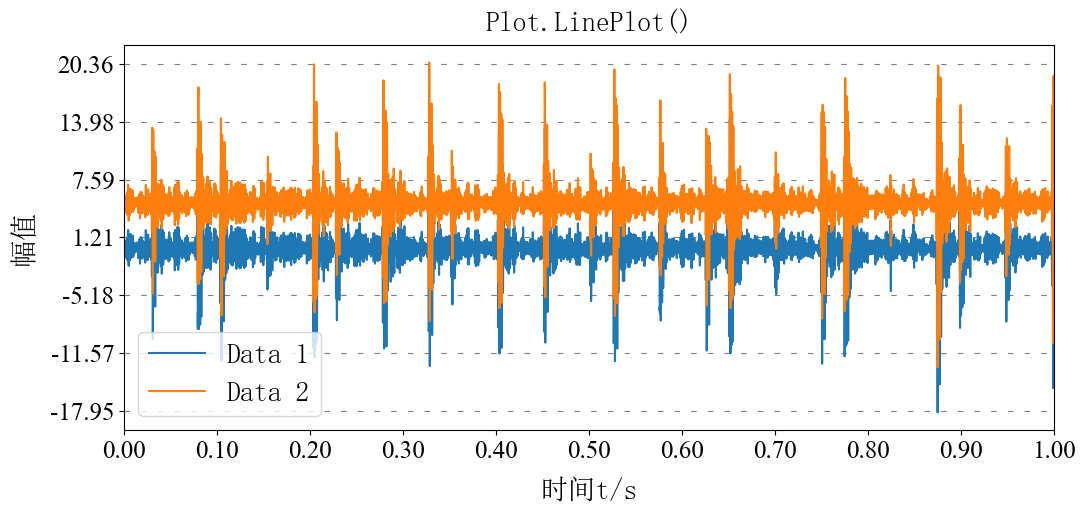

In [57]:
from PySP.Plot import LinePlot
from PySP.Signal import Signal

try:
    res = Signal(data=Data, fs=fs, label="测试信号")

    LinePlot(xlabel="时间t/s", ylabel="幅值", title="Plot.LinePlot()").show(
        Axis=res.t_Axis, Data=np.array([res.data,res.data+5]), 
    )
except Exception as e:
    print(e)

### 2.3 Plot.imshow()

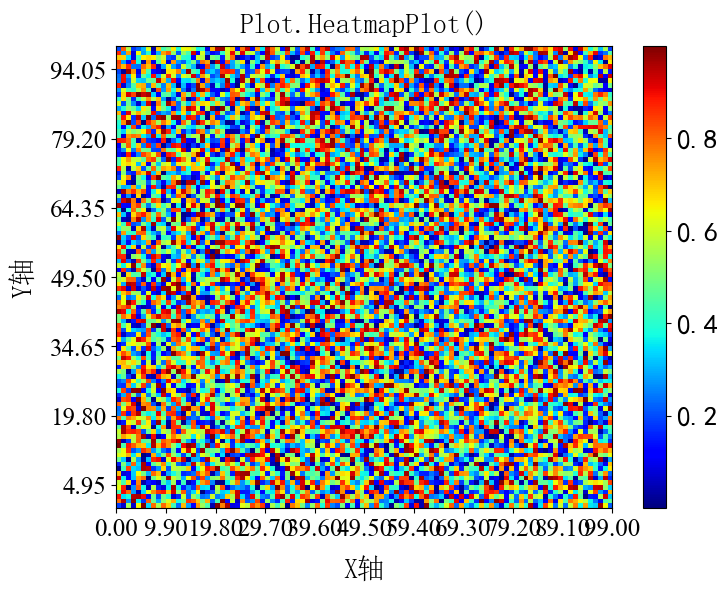

In [60]:
from PySP.Plot import HeatmapPlot
from numpy import random

try:
    Axis1 = np.arange(100)
    Axis2 = np.arange(100)
    data = random.random((100, 100))

    HeatmapPlot(
        figsize=(8, 6), xlabel="X轴", ylabel="Y轴", title="Plot.HeatmapPlot()"
    ).show(Axis1=Axis1, Axis2=Axis2, Data=data)
except Exception as e:
    print(e)

### 2.4 Plot.PeakfinderPlugin()

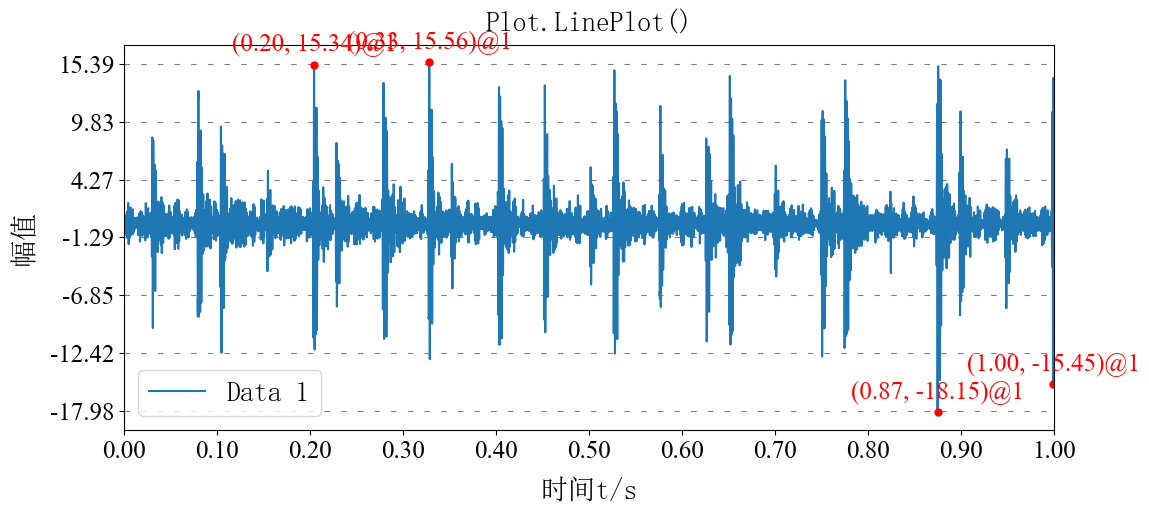

In [62]:
from PySP.Plot import PeakfinderPlugin,LinePlot
from PySP.Signal import Signal

try:
    res = Signal(data=Data, fs=fs, label="测试信号")

    fig=LinePlot(xlabel="时间t/s", ylabel="幅值", title="Plot.LinePlot()")
    fig.add_plugin(
        PeakfinderPlugin(
            height=15,
            distance=100,
        )
    )
    fig.show(Axis=res.t_Axis, Data=res.data)
except Exception as e:
    print(e)

## 3.BasicSP模块测试

### 3.1 BasicSP.window()

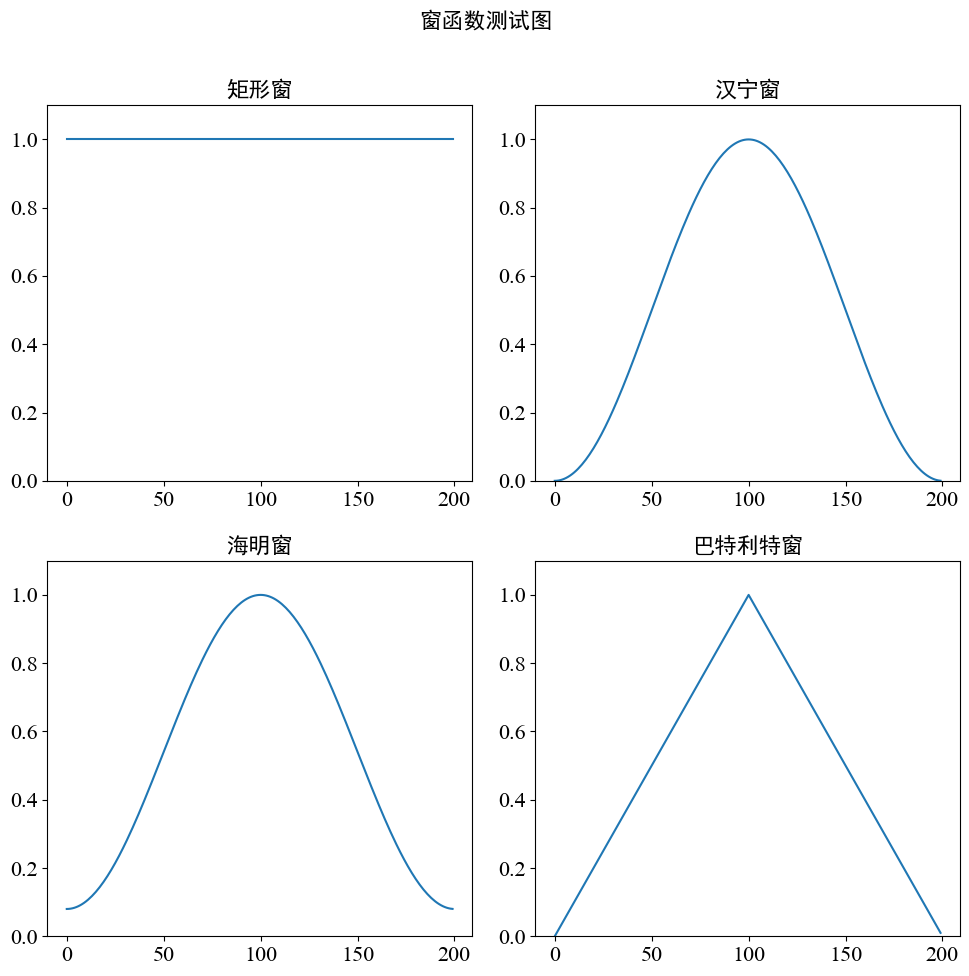

res1:  <class 'numpy.float64'>
res2:  <class 'numpy.float64'>
res3:  <class 'numpy.ndarray'>


In [21]:
from PySP.BasicSP import window

try:
    res=window(type="汉宁窗",num=200,padding=50,check=True)
    for i,r in enumerate(res):
        print(f"res{i+1}: ",type(r))
except Exception as e:
    print(e)

### 3.2 BasicSP.Time_Analysis()

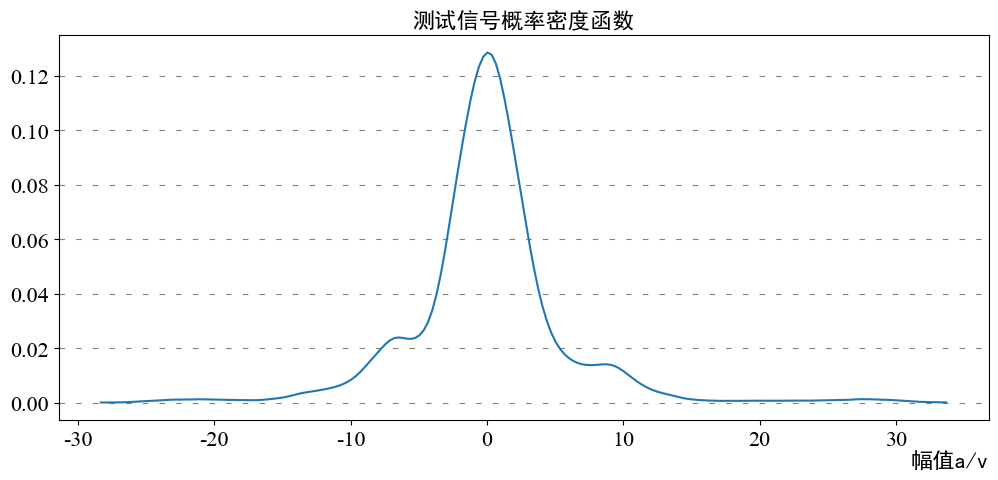

res1:  <class 'numpy.ndarray'>
res2:  <class 'numpy.ndarray'>


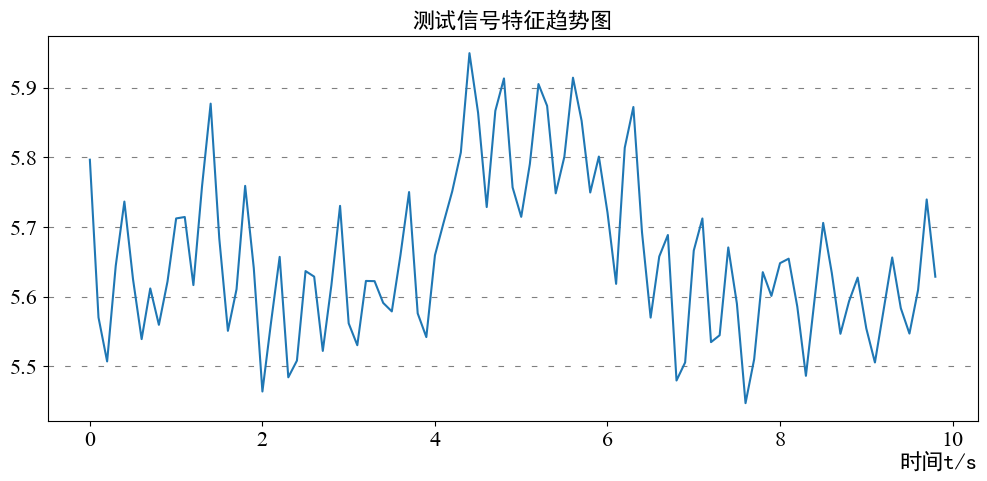

res1:  <class 'numpy.ndarray'>
res2:  <class 'numpy.ndarray'>


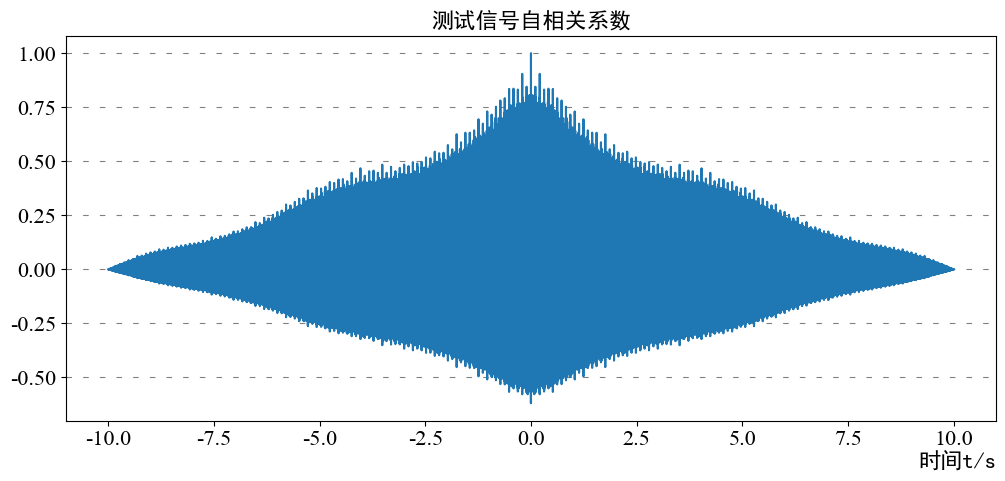

res1:  <class 'numpy.ndarray'>
res2:  <class 'numpy.ndarray'>


In [29]:
from PySP.BasicSP import Time_Analysis

try:
    Sig=Signal(data=Data,label='测试信号',fs=12000)
    # Time_Analysis.Psd()
    res=Time_Analysis(Sig=Sig,plot=True,plot_save=False,title=Sig.label+"概率密度函数",xlabel="幅值a/v").Pdf(samples=200)
    for i, r in enumerate(res):
        print(f"res{i+1}: ", type(r))
    # Time_Analysis.Trend()
    res=Time_Analysis(Sig=Sig,plot=True,plot_save=False,title=Sig.label+"特征趋势图",xlabel="时间t/s").Trend(Feature="有效值",step=0.1,SegLength=0.2)
    for i,r in enumerate(res):
        print(f"res{i+1}: ",type(r))
    # Time_Analysis.Autocorr()
    res=Time_Analysis(Sig=Sig,plot=True,plot_save=False,title=Sig.label+"自相关系数",xlabel="时间t/s").Autocorr(std=True,both=True)
    for i,r in enumerate(res):
        print(f"res{i+1}: ",type(r))
except Exception as e:
    print(e)

### 3.3 BasicSP.Frequency_Analysis()

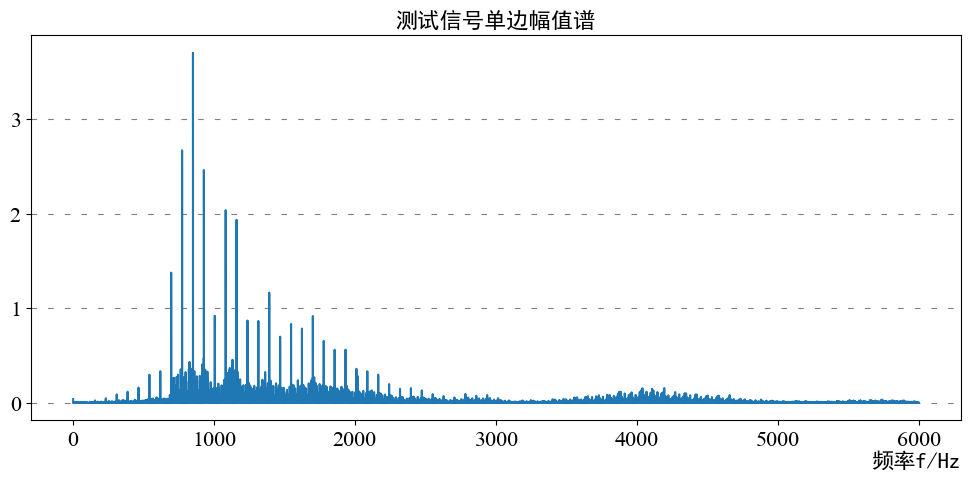

res1:  <class 'numpy.ndarray'>
res2:  <class 'numpy.ndarray'>


In [31]:
from PySP.BasicSP import Frequency_Analysis

try:
    Sig = Signal(data=Data, label="测试信号", fs=12000)
    # Frequency_Analysis.Cft()
    res = Frequency_Analysis(
        Sig=Sig,
        plot=True,
        plot_save=False,
        title=Sig.label + "单边幅值谱",
        xlabel="频率f/Hz",
    ).Cft(WinType="汉宁窗")
    for i, r in enumerate(res):
        print(f"res{i+1}: ", type(r))
except Exception as e:
    print(e)

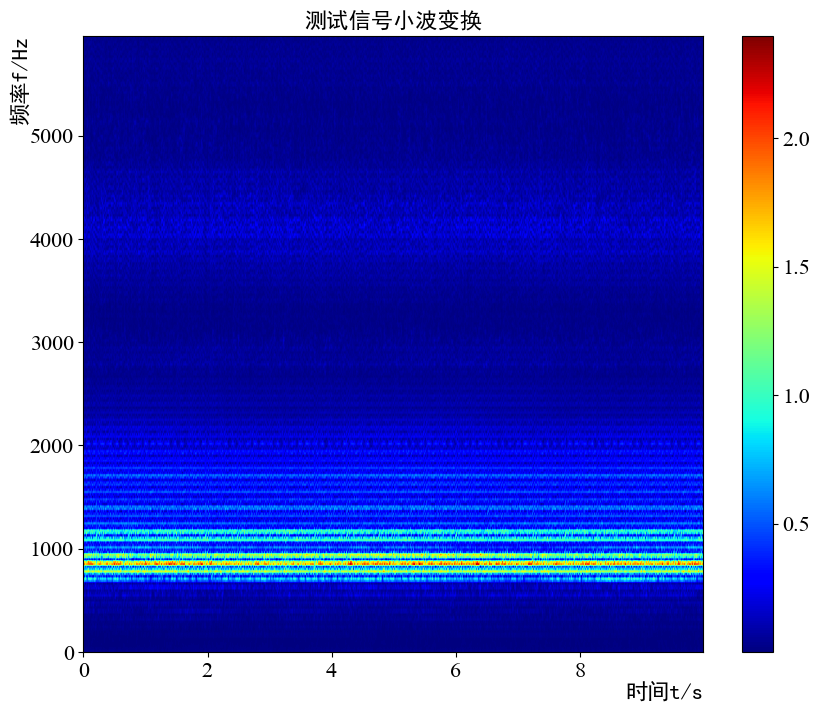

res1:  <class 'numpy.ndarray'>
res2:  <class 'numpy.ndarray'>
res3:  <class 'numpy.ndarray'>


In [39]:
from PySP.BasicSP import TimeFre_Analysis

try:
    Sig = Signal(data=Data, label="测试信号", fs=12000)
    # TimeFre_Analysis.Wavelet()
    res = TimeFre_Analysis(
        Sig=Sig,
        plot=True,
        plot_save=False,
        title=Sig.label + "小波变换",
        xlabel="时间t/s",
        ylabel="频率f/Hz",
    ).st_Cft(nperseg=513, nhop=128,WinType="汉宁窗")
    for i, r in enumerate(res):
        print(f"res{i+1}: ", type(r))
except Exception as e:
    print(e)